In [236]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import shutil
import time

from datetime import datetime
from itertools import product
from scipy.spatial.distance import cdist
from shapely import Point, LineString
from geopy.distance import geodesic
from shapely.strtree import STRtree
from sklearn.cluster import DBSCAN

In [237]:
#getting the cozie data
base_dir = 'D:/Desktop/MSc Thesis - Copy/'
cozie_df = pd.read_csv(os.path.join(base_dir, 'Data/Participant data/arda_survey_results_select_en.csv'), header = 0)
cozie_df.drop('Unnamed: 0', axis=1, inplace=True)

C:\Users\Michele\AppData\Local\Temp\ipykernel_10564\596002054.py:3: DtypeWarning: Columns (2,3,4,5,6,7,8,10,15,16,17,18,19,22,23,33,35,47,72,76,77,78,79) have mixed types. Specify dtype option on import or set low_memory=False.
  cozie_df = pd.read_csv(os.path.join(base_dir, 'Data/Participant data/arda_survey_results_select_en.csv'), header = 0)


In [238]:
# removing columns that are not needed
cozie_df.drop(['si_iphone_location_service_enabled', 'si_watch_location_service_enabled', 'ts_location_acquisition_method',
                  'ts_location_floor', 'ts_location_source_device', 'ws_location_acquisition_method', 'ws_location_floor',
                  'ws_location_source_device', 'wss_goal', 'wss_participation_days', 'wss_participation_time_end', 
                  'wss_participation_time_start', 'wss_reminder_enabeled', 'wss_reminder_interval', 'ts_HRV', 'ts_audio_exposure_environment', 
                  'ts_audio_exposure_headphones', 'ts_heart_rate', 'ts_oxygen_saturation', 'ts_resting_heart_rate', 'ts_sleep_REM', 'ts_sleep_awake',
                  'ts_sleep_core', 'ts_sleep_deep', 'ts_sleep_in_bed', 'ts_sleep_unspecified', 'ts_stand_time', 'ts_step_count', 'ts_walking_distance',
                  'ws_HRV', 'ws_audio_exposure_environment', 'ws_audio_exposure_headphones', 'ws_heart_rate', 'ws_oxygen_saturation', 
                  'ws_resting_heart_rate', 'ws_sleep_REM', 'ws_sleep_awake', 'ws_sleep_core', 'ws_sleep_deep', 'ws_sleep_in_bed', 'ws_sleep_unspecified',
                  'ws_stand_time', 'ws_step_count', 'ws_walking_distance', 'wss_time_out'], axis=1, inplace=True)

# removing additional columns that (should) not be needed
cozie_df.drop(['q_clothing', 'q_mood', ], axis=1, inplace=True)

print(cozie_df.columns) #printing column names

Index(['id_participant', 'location_change', 'q_activity_change_leisure',
       'q_activity_change_meal', 'q_activity_change_other',
       'q_activity_change_outdoors', 'q_activity_change_studying',
       'q_activity_change_working', 'q_activity_indoors',
       'q_activity_outdoors', 'q_adaptive_comfort', 'q_location',
       'q_location_change', 'q_location_leisure', 'q_location_meal',
       'q_location_other', 'q_location_studying', 'q_location_working',
       'q_thermal', 'timestamp', 'ts_altitude', 'ts_latitude',
       'ts_location_accuracy_horizontal', 'ts_location_accuracy_vertical',
       'ts_longitude', 'ts_timestamp_location', 'ws_altitude', 'ws_latitude',
       'ws_location_accuracy_horizontal', 'ws_location_accuracy_vertical',
       'ws_longitude', 'ws_survey_count', 'ws_timestamp_location',
       'ws_timestamp_start', 'wss_title'],
      dtype='object')


In [239]:
# replacing 0.0 coordinate value with NaN
cozie_df[['ts_longitude', 'ws_longitude', 'ts_latitude', 'ws_latitude']] = cozie_df[['ts_longitude', 'ws_longitude', 'ts_latitude', 'ws_latitude']].astype(float)
cozie_df[['ts_longitude', 'ws_longitude', 'ts_latitude', 'ws_latitude']] = cozie_df[['ts_longitude', 'ws_longitude', 'ts_latitude', 'ws_latitude']].replace({0: np.nan})

In [240]:
# dealing with timestamps
cozie_df['datetime'] = pd.to_datetime(cozie_df.timestamp, format='ISO8601')
cozie_df['date'] = cozie_df['datetime'].dt.date

cozie_df['datetime_ts_location'] = pd.to_datetime(cozie_df.ts_timestamp_location, format='ISO8601')
cozie_df['datetime_ws_location'] = pd.to_datetime(cozie_df.ws_timestamp_location, format='ISO8601')

cozie_df['merged_datetime'] = cozie_df['datetime_ts_location'].combine_first(cozie_df['datetime_ws_location'])
cozie_df['merged_date'] = cozie_df['merged_datetime'].dt.date

In [241]:
# dropping rows that are not needed 

# drop the Weather (short) wss title value
cozie_df.drop(cozie_df.loc[cozie_df.wss_title == 'Weather (short)'].index, inplace=True)

# drop rows with all null values
cozie_df = cozie_df.loc[cozie_df[
    ['location_change', 'q_activity_change_leisure', 'q_activity_change_meal', 'q_activity_change_other', 'q_activity_change_outdoors',
     'q_activity_change_studying', 'q_activity_change_working', 'q_activity_indoors', 'q_activity_outdoors', 'q_adaptive_comfort',
     'q_location', 'q_location_change', 'q_location_leisure', 'q_location_meal', 'q_location_other', 'q_location_studying',
     'q_location_working', 'q_thermal', 'ts_altitude', 'ts_latitude', 'ts_location_accuracy_horizontal', 'ts_location_accuracy_vertical', 
     'ts_longitude', 'ts_timestamp_location', 'ws_altitude', 'ws_latitude', 'ws_location_accuracy_horizontal', 'ws_location_accuracy_vertical', 
     'ws_longitude', 'ws_survey_count', 'ws_timestamp_location', 'ws_timestamp_start']].dropna(how='all').index].reset_index(drop=True)

# drop rows with no coordinates AND no Cozie survey
cozie_df = cozie_df.loc[cozie_df[
    ['q_activity_change_leisure', 'q_activity_change_meal', 'q_activity_change_other', 'q_activity_change_outdoors',
     'q_activity_change_studying', 'q_activity_change_working', 'q_activity_indoors', 'q_activity_outdoors', 'q_adaptive_comfort',
     'q_location', 'q_location_change', 'q_location_leisure', 'q_location_meal', 'q_location_other', 'q_location_studying',
     'q_location_working', 'q_thermal', 'ts_latitude', 'ts_longitude', 'ws_latitude', 'ws_longitude']].dropna(how='all').index] \
    .reset_index(drop=True)

# drop rows with no coordinates
cozie_df = cozie_df.loc[cozie_df[
    [ 'ts_latitude', 'ts_longitude', 'ws_latitude', 'ws_longitude']].dropna(how='all').index] \
    .reset_index(drop=True)

In [242]:
# creating new fields

# combining ts and ws latitude and longitude into new coordinate columns
cozie_df['latitude'] = np.where(cozie_df['ts_latitude'].notna(), cozie_df['ts_latitude'], cozie_df['ws_latitude'])
cozie_df['longitude'] = np.where(cozie_df['ts_longitude'].notna(), cozie_df['ts_longitude'], cozie_df['ws_longitude'])

cozie_df['latitude'] = cozie_df['latitude'].astype(float)
cozie_df['longitude'] = cozie_df['longitude'].astype(float)

# field for ws/ts coordinate source
cozie_df['coordinate_source'] = np.where(cozie_df['ts_latitude'].notna(), 'ts', 'ws')
cozie_df['source_change'] = cozie_df['coordinate_source'] == cozie_df['coordinate_source'].shift()

# dataset time range fields
start_date = cozie_df['date'].min()
end_date = cozie_df['date'].max()
total_weeks = (end_date - start_date).days  # number of complete weeks
unique_months = cozie_df['merged_datetime'].dt.strftime('%Y-%m').unique()

# single field with a location value
cozie_df['location'] = cozie_df[
    ['q_location_leisure', 'q_location_meal', 'q_location_other', 'q_location_studying', 'q_location_working']
].apply(lambda row: row.dropna().iloc[0] if not row.dropna().empty else None, axis=1)

In [243]:
# some basic information about the raw data:
print(f'Number of records: {cozie_df.shape[0]}') 
print(f"Data spans {(end_date - start_date).days} days from {start_date} to {end_date}")
print(f"Total weeks covered: {total_weeks}")
print(f"Months covered: {', '.join(unique_months)}")

Number of records: 54322
Data spans 51 days from 2023-10-04 to 2023-11-24
Total weeks covered: 51
Months covered: 2023-10, 2023-11


# __Dataset Cleaning__

### Filtering 1: removing reduntant rows

In [244]:
# keeping only the non-reduntant coordinate information
# rows are deemed non-redunant if enough time (time threshold) has passed since the last record from the same participant 

cozie_df = cozie_df.sort_values(by=['id_participant', 'merged_datetime'])
time_threshold = pd.Timedelta(seconds=60*5)

# defining a few fields to compare each coord with its previous one
cozie_df['prev_lat'] = cozie_df.groupby('id_participant')['latitude'].shift()
cozie_df['prev_lon'] = cozie_df.groupby('id_participant')['longitude'].shift()
cozie_df['prev_time'] = cozie_df.groupby('id_participant')['merged_datetime'].shift()
cozie_df['time_diff'] = (cozie_df['merged_datetime'] - cozie_df['prev_time']).dt.total_seconds()
cozie_df['geo_distance'] = cozie_df.apply(
    lambda row: geodesic((row['latitude'], row['longitude']), 
                         (row['prev_lat'], row['prev_lon'])
                        ).meters if pd.notnull(row['prev_lat']) and pd.notnull(row['prev_lon']) else 0,
    axis=1
)

# identify non-redundant rows
non_redundant_df = cozie_df[
    (cozie_df['id_participant'] != cozie_df['id_participant'].shift()) |            # keep first occurrence per participant
    (cozie_df['merged_datetime'].sub(cozie_df['merged_datetime'].shift()).abs() > time_threshold) # keep rows outside threshold
].copy()

print(f"Total rows before filtering 1: {len(cozie_df)}")
print(f"Total distinct positions (after removing redundant ones): {len(non_redundant_df)}")

Total rows before filtering 1: 54322
Total distinct positions (after removing redundant ones): 10181


In [245]:
# re-calculating the previous-coordinate fields after keeping only non-redundant rows
non_redundant_df['prev_lat'] = non_redundant_df.groupby('id_participant')['latitude'].shift()
non_redundant_df['prev_lon'] = non_redundant_df.groupby('id_participant')['longitude'].shift()
non_redundant_df['prev_time'] = non_redundant_df.groupby('id_participant')['merged_datetime'].shift()
non_redundant_df['time_diff'] = (non_redundant_df['merged_datetime'] - non_redundant_df['prev_time']).dt.total_seconds()
non_redundant_df['geo_distance'] = non_redundant_df.apply(
    lambda row: geodesic((row['latitude'], row['longitude']), 
                         (row['prev_lat'], row['prev_lon'])
                        ).meters if pd.notnull(row['prev_lat']) and pd.notnull(row['prev_lon']) else 0,
    axis=1
)

### Filtering 2: Removing positions with no change in coordinates

In [246]:
# records where the coordinates are IDENTICAL to the previous record, but with a location change being indicated are removed
non_redundant_df['same_coordinates'] = (non_redundant_df['latitude'] == non_redundant_df['prev_lat']) & \
                                       (non_redundant_df['longitude'] == non_redundant_df['prev_lon'])

# conditions for removal
conditions = (
    (non_redundant_df['same_coordinates']) &
    ((non_redundant_df['q_location_change'].isin(['Yes, less than 15 min', 'Yes, less than 30 min', 'Yes, less than 45 min', 'Yes, more than 40 min'])) |
        (non_redundant_df['location_change'] == True))
)

filtered_df = non_redundant_df[conditions == False]

# Drop the temporary 'same_coordinates' column
filtered_df = filtered_df.drop(columns=['same_coordinates'])

# Print the number of records before and after filtering
print(f"Number of records before filtering 2: {len(non_redundant_df)}")
print(f"Number of records after filtering 2: {len(filtered_df)}")
print(f"Total deleted rows by filtering 2: {len(non_redundant_df) - len(filtered_df)}")

Number of records before filtering 2: 10181
Number of records after filtering 2: 10149
Total deleted rows by filtering 2: 32


In [247]:
filtered_df['prev_lat'] = filtered_df.groupby('id_participant')['latitude'].shift()
filtered_df['prev_lon'] = filtered_df.groupby('id_participant')['longitude'].shift()
filtered_df['prev_time'] = filtered_df.groupby('id_participant')['merged_datetime'].shift()
filtered_df['time_diff'] = (filtered_df['merged_datetime'] - filtered_df['prev_time']).dt.total_seconds()
filtered_df['geo_distance'] = filtered_df.apply(
    lambda row: geodesic((row['latitude'], row['longitude']), 
                         (row['prev_lat'], row['prev_lon'])
                        ).meters if pd.notnull(row['prev_lat']) and pd.notnull(row['prev_lon']) else 0,
    axis=1
)

### Filtering 3

In [248]:
# getting the coordinates and timestamp of next location
filtered_df['next_lat'] = filtered_df.groupby('id_participant')['latitude'].shift(-1)
filtered_df['next_lon'] = filtered_df.groupby('id_participant')['longitude'].shift(-1)
filtered_df['next_time'] = filtered_df.groupby('id_participant')['merged_datetime'].shift(-1)

# distance from current to next location
filtered_df['next_geo_distance'] = filtered_df.groupby('id_participant')['geo_distance'].shift(-1)

# distance from previous to next location
filtered_df['prev_next_geo_distance'] = filtered_df.apply(
    lambda row: geodesic((row['prev_lat'], row['prev_lon']),
                         (row['next_lat'], row['next_lon'])).meters
    if pd.notnull(row['prev_lat']) and pd.notnull(row['prev_lon']) and 
       pd.notnull(row['next_lat']) and pd.notnull(row['next_lon']) else 0, axis=1
)

In [249]:
# computing the Basic Distance Ratio between the three points (previous, current, next)

filtered_df['distance_ratio'] = filtered_df['prev_next_geo_distance'] / (filtered_df['geo_distance'] + filtered_df['next_geo_distance'])
filtered_df['distance_ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)
filtered_df['distance_ratio'].fillna(0, inplace=True)

# implementing a time-scaling factor
filtered_df['next_time_diff'] = filtered_df.groupby('id_participant')['time_diff'].shift(-1)
filtered_df['max_time_diff'] = filtered_df[['time_diff', 'next_time_diff']].max(axis=1)
filtered_df['time_weight'] = 1 / (1 + np.log1p(filtered_df['max_time_diff']/60)) # time weight function in minutes (not seconds)

filtered_df['adjusted_distance_ratio'] = (
    filtered_df['distance_ratio'] * filtered_df['time_weight']
)


C:\Users\Michele\AppData\Local\Temp\ipykernel_10564\2535898079.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  filtered_df['distance_ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\Michele\AppData\Local\Temp\ipykernel_10564\2535898079.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

In [250]:
# calculating the speed from last location
non_redundant_df['speed'] = non_redundant_df['geo_distance'] / non_redundant_df['time_diff']
non_redundant_df['speed'].replace([float('inf'), -float('inf')], pd.NA, inplace=True)   # replacing infinite speeds with NaN (first point of each participant)

cozie_df['speed'] = cozie_df['geo_distance'] / cozie_df['time_diff']
cozie_df['speed'].replace([float('inf'), -float('inf')], pd.NA, inplace=True)      

filtered_df['speed'] = filtered_df['geo_distance'] / filtered_df['time_diff']
filtered_df['speed'].replace([float('inf'), -float('inf')], pd.NA, inplace=True)      # replacing infinite speeds with NaN (first point of each participant)

C:\Users\Michele\AppData\Local\Temp\ipykernel_10564\870664282.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  non_redundant_df['speed'].replace([float('inf'), -float('inf')], pd.NA, inplace=True)   # replacing infinite speeds with NaN (first point of each participant)
C:\Users\Michele\AppData\Local\Temp\ipykernel_10564\870664282.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method w

# __Grouping Positions into Nodes__

In [251]:
# import the building footprints 
buildings = gpd.read_file(os.path.join(base_dir, 'Data/GIS data/Building footprints/footprint_shapefile/Z_F_merge/merge_valid.shp'))

In [252]:
#  importing Seoul's extents
extents_gdf = gpd.read_file(os.path.join(base_dir, 'Data/Extents/Seoul extents/seoul_extents.shp'))
print(extents_gdf.crs) 
extents_gdf = extents_gdf.to_crs(buildings.crs)

print(extents_gdf.crs) 

EPSG:4326
EPSG:5174


In [253]:
neighborhood_extents_gdf = gpd.read_file(os.path.join(base_dir, 'shapefiles/crop/crop_neighborhood.shp'))
neighborhood_extents_gdf = neighborhood_extents_gdf.to_crs(buildings.crs)

In [254]:
extents_gdf["is_valid"] = extents_gdf.is_valid

In [255]:
# creating a GeoDataFrame from the filtered points
positions_gdf = gpd.GeoDataFrame(filtered_df, geometry=gpd.points_from_xy(filtered_df.longitude, filtered_df.latitude), crs='EPSG:4326')
positions_gdf = positions_gdf.to_crs(buildings.crs)

In [256]:
# marking positions that are outside Seoul's extents
# initializing the node id field
positions_gdf['node_id'] = np.nan

# function to check if a point is inside the extents
positions_gdf["in_Seoul"] = positions_gdf.geometry.within(extents_gdf.union_all())
positions_gdf["in_Neighborhood"] = positions_gdf.geometry.within(neighborhood_extents_gdf.union_all())

positions_seoul = positions_gdf[positions_gdf['in_Seoul'] == True]


In [257]:
# keeping only records outside Neighborhood every 30 minutes
outside_neighborhood_records = []
interval_seconds = 1800 

for pid, group in positions_gdf[positions_gdf["in_Seoul"] & ~positions_gdf["in_Neighborhood"]].groupby("id_participant"):
    group = group.sort_values("merged_datetime")
    last_time = None

    for _, row in group.iterrows():
        if last_time is None or (row['merged_datetime'] - last_time).total_seconds() >= interval_seconds:
            row_copy = row.copy()
            row_copy["node_id"] = -1  
            outside_neighborhood_records.append(row_copy)
            last_time = row['merged_datetime']

outside_neighborhood_df = pd.DataFrame(outside_neighborhood_records)

positions_seoul = pd.concat([
    positions_gdf[positions_gdf["in_Neighborhood"]],  # inside
    outside_neighborhood_df                           # outside (sampled)
]).sort_values(["id_participant", "merged_datetime"]).reset_index(drop=True)

In [258]:
print('Max id:', positions_gdf["node_id"].max())
print('Number of node ids:', len(positions_gdf["node_id"].unique()))

Max id: nan
Number of node ids: 1


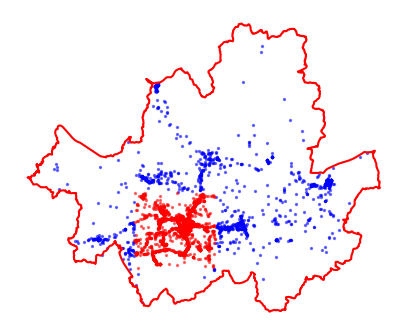

In [259]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 5))
extents_gdf.boundary.plot(ax=ax, color='red')  # Plot extents
positions_seoul[~positions_seoul['in_Neighborhood']].plot(ax=ax, color='blue', alpha=0.5, markersize=2)  # Plot points
positions_seoul[positions_seoul['in_Neighborhood']].plot(ax=ax, color='red', alpha=0.5, markersize=2)  # Plot points

ax.set_axis_off()  

plt.show()

In [260]:
positions_seoul = positions_seoul.sort_values(by=['id_participant', 'merged_datetime'])
positions_seoul.loc[~positions_seoul['in_Neighborhood'], 'node_id'] = -1

In [261]:
print('Max id:', positions_seoul["node_id"].max())
print('Number of node ids:', len(positions_seoul["node_id"].unique()))

Max id: -1.0
Number of node ids: 2


In [262]:
# Dividing the points outside Seoul into eight node IDs based on their directional quadrant:
# 1: NN, 2: NE, 3: EE, 4: SE, 5: SS, 6: SW, 7: WW, 8: NW

neighborhood_center = neighborhood_extents_gdf.union_all().centroid
center_x, center_y = neighborhood_center.x, neighborhood_center.y

def assign_cardinal_node_id(row):
    if row['node_id'] != -1:
        return row['node_id']
    
    dx = row.geometry.x - center_x  # Longitude difference
    dy = row.geometry.y - center_y  # Latitude difference

    # Angle in coordinates (0° = East, 90° = North)
    angle = np.degrees(np.arctan2(dy, dx)) 
    if angle < 0:
        angle += 360  # Convert angle to a 0-360° scale

    # Assigning node_id based on 45-degree sectors
    if 0 <= angle < 22.5 or angle >= 337.5:
        return 1  # EE (East)
    elif 22.5 <= angle < 67.5:
        return 2  # NE (North-East)
    elif 67.5 <= angle < 112.5:
        return 3  # NN (North)
    elif 112.5 <= angle < 157.5:
        return 4  # NW (North-West)
    elif 157.5 <= angle < 202.5:
        return 5  # WW (West)
    elif 202.5 <= angle < 247.5:
        return 6  # SW (South-West)
    elif 247.5 <= angle < 292.5:
        return 7  # SS (South)
    elif 292.5 <= angle < 337.5:
        return 8  # SE (South-East)

positions_seoul["node_id"] = positions_seoul.apply(assign_cardinal_node_id, axis=1)


In [263]:
print('Max id:', positions_seoul["node_id"].max())
print('Number of node ids:', len(positions_seoul["node_id"].unique()))

Max id: 8.0
Number of node ids: 8


C:\Users\Michele\AppData\Local\Temp\ipykernel_10564\689010691.py:28: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  wedge = Wedge(
C:\Users\Michele\AppData\Local\Temp\ipykernel_10564\689010691.py:36: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  positions_seoul[positions_seoul["node_id"] == node_id].plot(


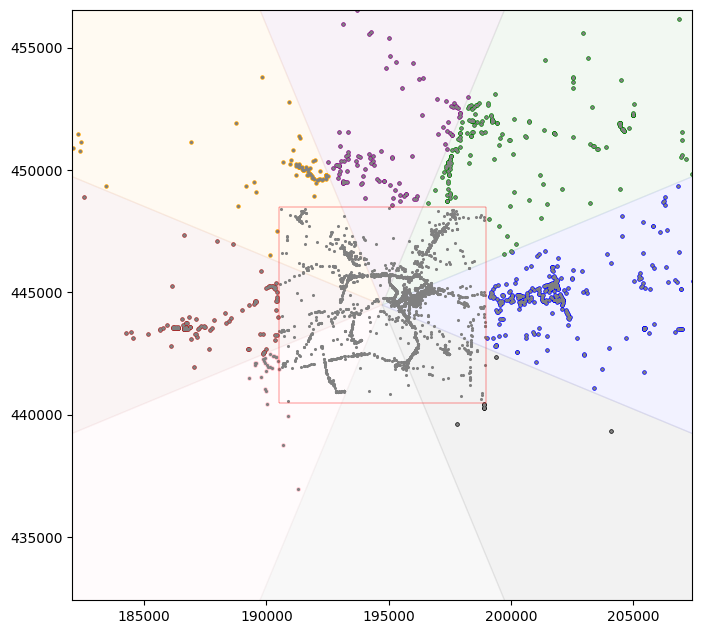

In [264]:
from matplotlib.patches import Wedge
fig, ax = plt.subplots(figsize=(8, 8))

# Define node colors (Same as points, but will use lower opacity for background)
node_colors = {
    1: "blue",
    2: "green",
    3: "purple",
    4: "orange",
    5: "brown",
    6: "pink",
    7: "gray",
    8: "black",
}

# Define max radius (adjustable based on data range)
max_radius = max(
    positions_seoul.geometry.x.max() - center_x,
    positions_seoul.geometry.y.max() - center_y
) * 1.2  # Scale up to ensure full coverage

# **Step 1: Add Transparent Background Slices**
for node_id, color in node_colors.items():
    start_angle = (node_id - 1) * 45 - 22.5  # Each slice is 45 degrees
    end_angle = node_id * 45 - 22.5

    # Add the Wedge (Pie Slice) to represent the quadrant
    wedge = Wedge(
        (center_x, center_y), max_radius, start_angle, end_angle,
        color=color, alpha=0.05, edgecolor="none", label=f"Quadrant {node_id}"
    )
    ax.add_patch(wedge)

# **Step 2: Overlay Points with Full Opacity**
for node_id, color in node_colors.items():
    positions_seoul[positions_seoul["node_id"] == node_id].plot(
        ax=ax, color=color, markersize=5, label=f"Node {node_id}"
    )

# Plot Seoul boundary
neighborhood_extents_gdf.boundary.plot(ax=ax, color='red', linewidth=0.3, label="Seoul Extents")

# Plot NaN node_id points in light grey
positions_seoul[positions_seoul["in_Seoul"]].plot(ax=ax, color='grey', markersize=1.5, label="Unknown (NaN)")

# **Step 3: Adjust Map Limits**
minx, miny, maxx, maxy = neighborhood_extents_gdf.total_bounds
x_margin = (maxx - minx) * 1
y_margin = (maxy - miny) * 1

ax.set_xlim(minx - x_margin, maxx + x_margin)
ax.set_ylim(miny - y_margin, maxy + y_margin)

# **Step 4: Final Adjustments**
#plt.legend()
plt.gca().set_aspect('equal')  # Keep the proportions correct
plt.show()

In [265]:
# manually fixing a location with a wrong value

target_timestamp = "2023-11-15 10:13:59.690000+09:00"
target_participant = 'arda21'

matching_records = positions_seoul[
    (positions_seoul["id_participant"] == target_participant) &
    (positions_seoul["timestamp"] == target_timestamp)
]

if len(matching_records) == 1:
    # Modify the location attribute (set to NaN or another value)
    positions_seoul.loc[
        (positions_seoul["id_participant"] == target_participant) &
        (positions_seoul["timestamp"] == target_timestamp),
        "location"
    ] = np.nan

In [266]:
print('Max id:', positions_seoul["node_id"].max())
print('Number of node ids:', len(positions_seoul["node_id"].unique()))

Max id: 8.0
Number of node ids: 8


# __Creating Nodes__

In [267]:
import rasterio
from rasterio.sample import sample_gen

In [268]:
positions_seoul['altitude'] = np.where(positions_seoul['ts_altitude'].notna(), positions_seoul['ts_altitude'], positions_seoul['ws_altitude'])
positions_seoul['accuracy_horizontal'] = np.where(positions_seoul['ts_location_accuracy_horizontal'].notna(), positions_seoul['ts_location_accuracy_horizontal'], positions_seoul['ws_location_accuracy_horizontal'])
positions_seoul['accuracy_vertical'] = np.where(positions_seoul['ts_location_accuracy_vertical'].notna(), positions_seoul['ts_location_accuracy_vertical'], positions_seoul['ws_location_accuracy_vertical'])

positions_seoul['altitude'] = positions_seoul['altitude'].astype(float)
positions_seoul['accuracy_horizontal'] = positions_seoul['accuracy_horizontal'].astype(float)
positions_seoul['accuracy_vertical'] = positions_seoul['accuracy_vertical'].astype(float)

In [269]:
# import terrain tiff file

terrain_tiff_path = os.path.join(base_dir, 'Data/GIS data/Terrain/dtm_90_cropped_proj.tif')

with rasterio.open(terrain_tiff_path) as src:
    # Sample the terrain data at the coordinates of the points
    coords = [(x, y) for x, y in zip(positions_seoul.geometry.x, positions_seoul.geometry.y)]
    terrain_heights = list(src.sample(coords))
    terrain_heights = np.array(terrain_heights).flatten()


positions_seoul['latitude'] = positions_seoul['latitude'].astype(float)
positions_seoul['longitude'] = positions_seoul['longitude'].astype(float)


positions_seoul['terrain_height'] = terrain_heights
positions_seoul['height_above_ground'] = positions_seoul['altitude'] - positions_seoul['terrain_height']


In [270]:
print(buildings.crs)

EPSG:5174


In [271]:
before = len(positions_seoul)

# remove rows with horizontal accuracy over 100m
positions_seoul = positions_seoul[positions_seoul['accuracy_horizontal'] <= 100]
print (f"Removed {before - len(positions_seoul)} rows with horizontal accuracy over 100m.")
before = len(positions_seoul)

# load railway and road line data
dir_urban = 'D:/Desktop/MSc Thesis - Copy/Data/GIS data/Urban cropped/'
railways = gpd.read_file(dir_urban + 'railways_cropped_cleaned.shp').to_crs(buildings.crs)
roads = gpd.read_file(dir_urban + 'roads_cropped_cleaned.shp').to_crs(buildings.crs)
roads = roads[roads['fclass'].isin(['primary', 'secondary', 'tertiary', 'residential', 'service', 'living_street', 'trunk'])]
combined_lines = pd.concat([roads, railways], ignore_index=True)
underground_lines = combined_lines[combined_lines['layer'] < 0].copy()


# assign underground tag, and remove points that have vertical accuracy over 30m
positions_seoul['buffer_radius'] = positions_seoul['accuracy_horizontal'].clip(upper=50)
positions_seoul['Underground'] = False

underground_candidates = positions_seoul[positions_seoul['height_above_ground'] < 0].copy()
underground_candidates['geometry'] = underground_candidates.buffer(underground_candidates['buffer_radius'])
underground_matches = gpd.sjoin(underground_candidates, underground_lines, how='inner', predicate='intersects')

matches_valid = underground_matches[
    (underground_matches['height_above_ground'] + underground_matches['accuracy_vertical'] < 0) &
    ((underground_matches['q_location'].isna()) | (underground_matches['q_location'] == 'Outdoors'))
]

to_remove = underground_matches[
    (underground_matches['accuracy_vertical'] > 30) &
    ((underground_matches['q_location'].isna()) | (underground_matches['q_location'] == 'Outdoors'))
].index

positions_seoul.loc[matches_valid.index, 'Underground'] = True
positions_seoul = positions_seoul.drop(index=to_remove)

print (f"Removed {before - len(positions_seoul)} rows with horizontal accuracy over 100m.")
before = len(positions_seoul)

Removed 774 rows with horizontal accuracy over 100m.
Removed 109 rows with horizontal accuracy over 100m.


C:\Users\Michele\AppData\Local\Temp\ipykernel_10564\1555993687.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:5174

  underground_matches = gpd.sjoin(underground_candidates, underground_lines, how='inner', predicate='intersects')


In [272]:

#positions_seoul.to_file(base_dir + 'Data/GIS data/Urban cropped/tests/vacc1.shp', driver='ESRI Shapefile')

In [273]:
print('Max id:', positions_seoul["node_id"].max())
print('Number of node ids:', len(positions_seoul["node_id"].unique()))

Max id: 8.0
Number of node ids: 8


Home Locations

In [274]:
home_locations = positions_seoul[(positions_seoul['in_Neighborhood']) & (positions_seoul['location'] == 'Home')]
home_node_mapping = {}  # dictionary to track home node IDs
max_existing_node_id = positions_seoul['node_id'].max()

for participant_id in home_locations['id_participant'].unique():        # assigning a unique node_id for each participant's home location
    if participant_id in ['arda17']:                                    # skip participant 17 (they have 2 homes)
        continue
    max_existing_node_id += 1 
    home_node_mapping[participant_id] = max_existing_node_id

# assigning the correct home node_id to each home location
def assign_home_node_id(row):
    if row['id_participant'] in home_node_mapping and row['location'] == 'Home' and row['in_Neighborhood']:
        return home_node_mapping[row['id_participant']]
    return row['node_id']  # Keep existing node_id if not a home location

positions_seoul['node_id'] = positions_seoul.apply(assign_home_node_id, axis=1)

# assinging two home nodes for participant 17 (using a latitude threshold)
max_existing_node_id = positions_seoul['node_id'].max()
positions_seoul.loc[
    (positions_seoul["id_participant"] == 17) &
    (positions_seoul["location"] == "Home") &
    (positions_seoul["latitude"] >= 37.53) &
    (positions_seoul['in_Neighborhood'] == True),
    "node_id"
] = max_existing_node_id + 1 # First home node_id

max_existing_node_id = positions_seoul['node_id'].max()
positions_seoul.loc[
    (positions_seoul["id_participant"] == 17) &
    (positions_seoul["location"] == "Home") &
    (positions_seoul["latitude"] < 37.53) &
    (positions_seoul['in_Neighborhood'] == True),
    "node_id"
] = max_existing_node_id + 1# Second home node_id


print('Home node assignments:', home_node_mapping)
print(positions_seoul['node_id'].value_counts())
print(max_existing_node_id)

Home node assignments: {'arda01': np.float64(9.0), 'arda03': np.float64(10.0), 'arda07': np.float64(11.0), 'arda08': np.float64(12.0), 'arda09': np.float64(13.0), 'arda10': np.float64(14.0), 'arda11': np.float64(15.0), 'arda12': np.float64(16.0), 'arda13': np.float64(17.0), 'arda15': np.float64(18.0), 'arda16': np.float64(19.0), 'arda18': np.float64(20.0), 'arda19': np.float64(21.0), 'arda21': np.float64(22.0), 'arda22': np.float64(23.0)}
node_id
1.0     457
2.0     162
3.0     156
4.0      96
5.0      93
14.0     50
11.0     35
16.0     32
6.0      24
13.0     22
22.0     19
12.0     19
19.0     14
18.0     11
17.0     11
20.0     10
9.0       9
21.0      7
15.0      5
10.0      5
23.0      3
8.0       1
Name: count, dtype: int64
23.0


In [275]:
print('Max id:', positions_seoul["node_id"].max())
print('Number of node ids:', len(positions_seoul["node_id"].unique()))

Max id: 23.0
Number of node ids: 23


In [276]:
# using the survey start time as the datetime value for home locations
# since there is occasionally some large delay between the survey and location timestamps

positions_seoul['ws_timestamp_start'] = pd.to_datetime(positions_seoul['ws_timestamp_start'], errors='coerce')

positions_seoul.loc[
    (positions_seoul['location'] == 'Home') & (positions_seoul['in_Seoul']),
    'merged_datetime'
] = positions_seoul['ws_timestamp_start']


Indoor Buildings

In [277]:
# getting the building id for points inside a building 
positions_seoul.set_crs(buildings.crs, inplace=True)

positions_seoul.loc[~positions_seoul["Underground"], "building_id"] = gpd.sjoin(
    positions_seoul[~positions_seoul["Underground"]],
    buildings[['geometry', 'BD_MGT_SN']], 
    how='left', 
    predicate='within'
    )["BD_MGT_SN"].values

print(buildings.crs)

positions_seoul.loc[positions_seoul["q_location"] == "Outdoors", "building_id"] = np.nan

EPSG:5174


In [278]:
# assigning closest building id to 'Indoors' records that fall outside a building

filtered_positions = positions_seoul[
    (positions_seoul['building_id'].isna()) &
    (positions_seoul['q_location'] == 'Indoors') &
    (~positions_seoul['Underground'])
].copy()

buildings_tree = STRtree(buildings.geometry)                        # spatial index for buildings for faster lookup

matched_building_ids = buildings['BD_MGT_SN'].iloc[                 # find the nearest building for each point and its BD_MGT_SN id
    buildings_tree.nearest(filtered_positions.geometry.values)
].values

filtered_positions["building_id"] = matched_building_ids            # assign the building id to the filtered positions

positions_seoul.update(filtered_positions)                          # update the original positions dataframe

In [279]:
# assigning the same building id to records where no change in location is indicated

# survey rows where the location is indoors and no location change is indicated
for participant_id, group in positions_seoul.groupby("id_participant"):
    last_building_id = None
    last_indoor_point = None
    last_indoor_time = None

    for idx, row in group.iterrows():
        if pd.notna(row['q_location']) and row['q_location'] == 'Indoors':
            if row['q_location_change'] == 'No, I did not change location' and last_building_id is not None:
                time_diff = (row['merged_datetime'] - last_indoor_time).total_seconds() / 3600
                distance = row['geometry'].distance(last_indoor_point)

                if time_diff < 1 and distance < 50:  # only assign same building if time and distance conditions are met
                    positions_seoul.at[idx, 'building_id'] = last_building_id
    
    if pd.notna(row['building_id']):
        last_building_id = row['building_id']
        last_indoor_point = row['geometry']
        last_indoor_time = row['merged_datetime']

    # other rows between survey rows with no change in location
    elif pd.isna(row['q_location']):
        if last_building_id is not None:
            time_diff = (row['merged_datetime'] - last_indoor_time).total_seconds() / 3600
            distance = row['geometry'].distance(last_indoor_point)

            if time_diff < 1 and distance < 50:  # only assign same building if time and distance conditions are met
                positions_seoul.at[idx, 'building_id'] = last_building_id

In [280]:
print('Max id:', positions_seoul["node_id"].max())
print('Number of node ids:', len(positions_seoul["node_id"].unique()))

Max id: 23.0
Number of node ids: 23


In [281]:
# Making sure home nodes have the same building id

home_building_map = (
    positions_seoul[positions_seoul['node_id'] > 8]
    .groupby('node_id')['building_id']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
    .dropna()
    .to_dict()
)

# force all positions for that home node to use that building ID
for node_id, building_id in home_building_map.items():
    positions_seoul.loc[positions_seoul['node_id'] == node_id, 'building_id'] = building_id

# appling the home ID to all other positions assigned to that building
for node_id, building_id in home_building_map.items():
    positions_seoul.loc[
        (positions_seoul['building_id'] == building_id) &
        (positions_seoul['node_id'].isna()),  # only update unassigned ones
        'node_id'
    ] = node_id

In [282]:
# giving a unique node_id to rows that have the same building id
max_existing_node_id = positions_seoul["node_id"].max()

building_points = positions_seoul[
    (positions_seoul["building_id"].notna()) & 
    (positions_seoul["node_id"].isna())
    ].copy()

unique_buildings = building_points["building_id"].unique()
building_id_to_node_id = {bid: max_existing_node_id + i + 1 for i, bid in enumerate(unique_buildings)}

building_points["node_id"] = building_points["building_id"].map(building_id_to_node_id)

positions_seoul.update(building_points)

In [283]:
print('Max id:', positions_seoul["node_id"].max())
print('Number of node ids:', len(positions_seoul["node_id"].unique()))

Max id: 328.0
Number of node ids: 328


Outdoor: Green Areas

In [284]:
from shapely.ops import unary_union
from shapely.geometry import MultiPolygon

# load green area polygons
green_areas = gpd.read_file(dir_urban + 'landuse_cropped.shp').to_crs(buildings.crs)
green_areas = green_areas[green_areas['fclass'].isin(['farmyard', 'forest', 'grass', 'heath', 'meadow', 'nature_reserve', 'orchard', 'park', 'recreation_ground','scrub', 'vineyard'])]
green_areas["area"] = green_areas.geometry.area
green_areas = green_areas.sort_values("area", ascending=False)

green_areas = green_areas.explode(index_parts=False).reset_index(drop=True)
merged_geoms = unary_union(green_areas.geometry)
if isinstance(merged_geoms, MultiPolygon):
    merged_geoms = list(merged_geoms.geoms)
else:
    merged_geoms = [merged_geoms]
green_areas_merged = gpd.GeoDataFrame(geometry=merged_geoms, crs=green_areas.crs)

In [285]:
print(green_areas_merged.is_empty.any())        # Should be False
print(green_areas_merged.geometry.is_valid.all())  # Should be True

False
True


In [286]:
outdoor_points = positions_seoul[positions_seoul['node_id'].isna() & ~positions_seoul['Underground']].copy()

In [287]:
green_areas_merged = green_areas_merged.reset_index(drop=True)



# getting the building id for points inside a building 
positions_seoul.set_crs(buildings.crs, inplace=True)

joined = gpd.sjoin(
    positions_seoul[positions_seoul['node_id'].isna() & ~positions_seoul['Underground']],
    green_areas_merged[['geometry']], 
    how='left', 
    predicate='within'
    )


positions_seoul.loc[joined.index, "green_id"] = joined["index_right"].values
positions_seoul.loc[joined.index, "in_green_area_node"] = True


# green_area_to_node_id = {}
# inside_green = positions_seoul[positions_seoul["green_id"].notna() & positions_seoul["node_id"].notna()]

# for gid, group in inside_green.groupby("green_id"):
#     # Use the mode (most frequent) node_id just in case
#     node_id = group["node_id"].mode().iloc[0]
#     green_area_to_node_id[int(gid)] = int(node_id)







# outdoor_in_green = gpd.sjoin(outdoor_points, green_areas_merged, how='left', predicate='within')
# outdoor_in_green = outdoor_in_green[outdoor_in_green["index_right"].notna()].copy()

# max_existing_node_id = positions_seoul["node_id"].max()

# green_area_to_node_id = {
#     idx : max_existing_node_id + i + 1
#     for i, idx in enumerate(outdoor_in_green['index_right'].unique())
# }

# positions_seoul["in_green_area_node"] = False
# outdoor_in_green["in_green_area_node"] = True
# outdoor_in_green["node_id"] = outdoor_in_green["index_right"].map(green_area_to_node_id)


# positions_seoul.update(outdoor_in_green[["node_id"]])
# positions_seoul.update(outdoor_in_green[["in_green_area_node"]])


C:\Users\Michele\AppData\Local\Temp\ipykernel_10564\2336446854.py:20: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


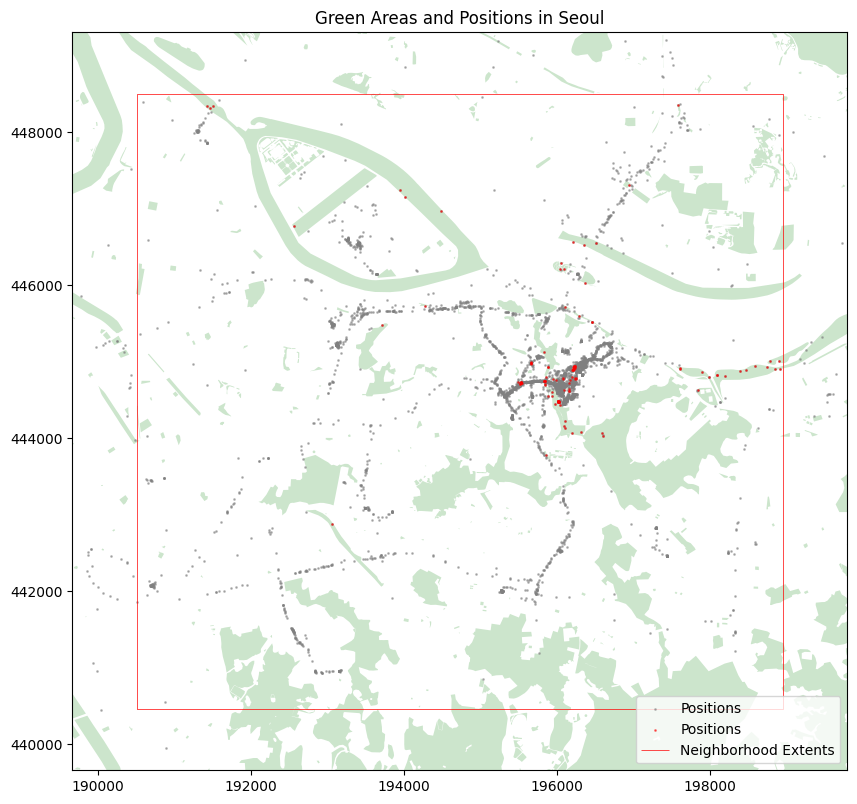

In [288]:
fig, ax = plt.subplots(figsize=(10, 10))
green_areas_merged.plot(ax=ax, color='green', alpha=0.2, label='Green Areas' )

positions_seoul.plot(ax=ax, color='grey', markersize=1, alpha= 0.5, label='Positions')
#positions_seoul[positions_seoul['in_green_area_node']==False].plot(ax=ax, color='red', markersize=1, alpha= 0.5, label='Positions')

positions_seoul[positions_seoul['green_id']>=0].plot(ax=ax, color='red', markersize=1, alpha= 0.5, label='Positions')


ax.set_title('Green Areas and Positions in Seoul')

minx, miny, maxx, maxy = neighborhood_extents_gdf.total_bounds
x_margin = (maxx - minx) * 0.1
y_margin = (maxy - miny) * 0.1

ax.set_xlim(minx - x_margin, maxx + x_margin)
ax.set_ylim(miny - y_margin, maxy + y_margin)

neighborhood_extents_gdf.boundary.plot(ax=ax, color='red', linewidth=0.5, label='Neighborhood Extents')
plt.legend()
plt.show()

In [289]:
# positions_seoul[positions_seoul['in_green_area_node'] == True].to_file(
#     os.path.join(base_dir, 'Data/GIS data/Urban cropped/tests/positions_seoul_green_areas4.shp'),
#     driver='ESRI Shapefile'
# )

positions_seoul.to_file(
    os.path.join(base_dir, 'Data/GIS data/Urban cropped/tests/positions_seoul5.shp'),
    driver='ESRI Shapefile'
)

C:\Users\Michele\AppData\Local\Temp\ipykernel_10564\3806101584.py:6: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  positions_seoul.to_file(
d:\Desktop\MSc Thesis - Copy\scripts\.venvth\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'id_participant' to 'id_partici'
  ogr_write(
d:\Desktop\MSc Thesis - Copy\scripts\.venvth\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'location_change' to 'location_c'
  ogr_write(
d:\Desktop\MSc Thesis - Copy\scripts\.venvth\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'q_activity_change_leisure' to 'q_activity'
  ogr_write(
d:\Desktop\MSc Thesis - Copy\scripts\.venvth\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'q_activity_change_meal' to 'q_activi_1'
  ogr_write(
d:\Desktop\MSc Thesis - Copy\scripts\.venvth\Lib\site-packages\pyogrio\r

Remaining points: Transport Line / Open Area

In [290]:
def split_line_by_max_length(line: LineString, max_len: float) -> list:
    if line.length <= max_len:
        return [line]
    num_segments = int(np.ceil(line.length / max_len))
    distances = np.linspace(0, line.length, num_segments + 1)
    return [
        LineString([line.interpolate(distances[i]), line.interpolate(distances[i + 1])])
        for i in range(len(distances) - 1)
    ]

In [291]:
remaining_points = positions_seoul[positions_seoul['node_id'].isna() & positions_seoul['green_id'].isna()].copy()

green_geoms = green_areas_merged.geometry
green_tree = STRtree(green_geoms)


all_lines = pd.concat([roads, railways], ignore_index=True)
all_lines = all_lines.to_crs(buildings.crs)

max_len = 300  # meters
split_records = []

for idx, row in all_lines.iterrows():
    segments = split_line_by_max_length(row.geometry, max_len)
    for seg in segments:
        # Copy all original attributes
        record = row.copy()
        record['geometry'] = seg
        split_records.append(record)

all_lines = gpd.GeoDataFrame(split_records, crs=buildings.crs).reset_index(drop=True)

aboveground_lines = all_lines[all_lines['layer'] >= 0].copy()
aboveground_lines = aboveground_lines.reset_index(drop=True)
line_geoms = aboveground_lines.geometry
line_tree = STRtree(line_geoms)

underground_lines = all_lines[all_lines['layer'] < 0].copy()
underground_lines = underground_lines.reset_index(drop=True)
underground_geoms = underground_lines.geometry
underground_tree = STRtree(underground_geoms)

In [292]:
# Filter only outdoor, non-green, non-underground positions without a node_id
# positions_seoul

remaining_points = positions_seoul[
    positions_seoul['node_id'].isna() &
    positions_seoul['green_id'].isna()
].copy()

# Create reverse geometry lookup (geom ID to index in original df)
geom_to_index_green = {id(geom): i for i, geom in enumerate(green_geoms)}
geom_to_index_line = {id(geom): i for i, geom in enumerate(line_geoms)}
geom_to_index_underground = {id(geom): i for i, geom in enumerate(underground_geoms)}


max_existing_node_id = positions_seoul["node_id"].max()



for idx, row in remaining_points.iterrows():
    pt = row.geometry
    if row['Underground'] == False:
        nearest_green = green_geoms[green_tree.nearest(pt)]
        nearest_line = line_geoms[line_tree.nearest(pt)]

        # Compare distances
        dist_green = pt.distance(nearest_green)
        dist_line = pt.distance(nearest_line)

        if dist_green < dist_line:
            # Assign to green area
            green_idx = geom_to_index_green[id(nearest_green)]

            # if green_idx not in green_area_to_node_id:
            #     max_existing_node_id += 1
            #     green_area_to_node_id[green_idx] = max_existing_node_id

            positions_seoul.at[idx, "green_id"] = green_idx
            # positions_seoul.at[idx, "node_id"] = green_area_to_node_id[green_idx]
            positions_seoul.at[idx, "in_green_area_node"] = True
            positions_seoul.at[idx, "node_type"] = "green_area"

        else:
            
            line_idx = geom_to_index_line[id(nearest_line)]
            positions_seoul.at[idx, "line_id"] = line_idx
            positions_seoul.at[idx, "in_green_area_node"] = False
            positions_seoul.at[idx, "node_type"] = "transport_line"
    else:
        nearest_underground = underground_geoms[underground_tree.nearest(pt)]
        underground_idx = geom_to_index_underground[id(nearest_underground)]
        positions_seoul.at[idx, "underground_id"] = underground_idx
        positions_seoul.at[idx, "in_green_area_node"] = False
        positions_seoul.at[idx, "node_type"] = "transport_line"




# # Iterate over remaining points
# for idx, row in remaining_points.iterrows():
#     pt = row.geometry
#     nearest_green = green_geoms[green_tree.nearest(pt)]
#     nearest_line = line_geoms[line_tree.nearest(pt)]

#     # Compare distances
#     dist_green = pt.distance(nearest_green)
#     dist_line = pt.distance(nearest_line)

#     if dist_green < dist_line:
#         # Assign to green area
#         green_idx = geom_to_index_green[id(nearest_green)]

#         # if green_idx not in green_area_to_node_id:
#         #     max_existing_node_id += 1
#         #     green_area_to_node_id[green_idx] = max_existing_node_id

#         positions_seoul.at[idx, "green_id"] = green_idx
#         # positions_seoul.at[idx, "node_id"] = green_area_to_node_id[green_idx]
#         positions_seoul.at[idx, "in_green_area_node"] = True
#         positions_seoul.at[idx, "node_type"] = "green_area"

#     else:
#         # Leave node_id as NaN for transport line — will assign later
#         positions_seoul.at[idx, "in_green_area_node"] = False
#         positions_seoul.at[idx, "node_type"] = "transport_line"



In [293]:
# unassigned_green = positions_seoul[
#     positions_seoul["green_id"].notna() & 
#     positions_seoul["node_id"].isna()
# ].copy()

# green_ids = unassigned_green["green_id"].unique()

# green_area_to_node_id = {
#     gid: max_existing_node_id + i + 1
#     for i, gid in enumerate(sorted(green_ids))
# }

# positions_seoul.loc[unassigned_green.index, "node_id"] = unassigned_green["green_id"].map(lambda x: green_area_to_node_id.get(x))

# positions_seoul.loc[positions_seoul["Underground"] & positions_seoul["node_id"].isna(),["node_type", "in_green_area_node"]] = ["transport_line", False]

green_ids = positions_seoul.loc[
    positions_seoul['green_id'].notna() & positions_seoul['node_id'].isna(),
    'green_id'
].drop_duplicates().astype(int)

max_existing_node_id = int(positions_seoul['node_id'].max())
green_area_to_node_id = {
    int(gid): max_existing_node_id + i + 1
    for i, gid in enumerate(sorted(green_ids))
}

positions_seoul.loc[
    positions_seoul['green_id'].notna() & positions_seoul['node_id'].isna(),
    'node_id'
] = positions_seoul.loc[
    positions_seoul['green_id'].notna() & positions_seoul['node_id'].isna(), 'green_id'
].map(lambda x: green_area_to_node_id.get(int(x)) if pd.notna(x) else np.nan)




line_ids = positions_seoul.loc[
    positions_seoul['line_id'].notna() & positions_seoul['node_id'].isna(),
    'line_id'
].drop_duplicates().astype(int)

max_existing_node_id = int(positions_seoul['node_id'].max())
line_to_node_id = {
    int(lid): max_existing_node_id + i + 1
    for i, lid in enumerate(sorted(line_ids))
}

positions_seoul.loc[
    positions_seoul['line_id'].notna() & positions_seoul['node_id'].isna(),
    'node_id'
] = positions_seoul.loc[
    positions_seoul['line_id'].notna() & positions_seoul['node_id'].isna(), 'line_id'
].map(lambda x: line_to_node_id.get(int(x)) if pd.notna(x) else np.nan)





underground_ids = positions_seoul.loc[
    positions_seoul['underground_id'].notna() & positions_seoul['node_id'].isna(),
    'underground_id'
].drop_duplicates().astype(int)

max_existing_node_id = int(positions_seoul['node_id'].max())
underground_to_node_id = {
    int(uid): max_existing_node_id + i + 1
    for i, uid in enumerate(sorted(underground_ids))
}

positions_seoul.loc[
    positions_seoul['underground_id'].notna() & positions_seoul['node_id'].isna(),
    'node_id'
] = positions_seoul.loc[
    positions_seoul['underground_id'].notna() & positions_seoul['node_id'].isna(), 'underground_id'
].map(lambda x: underground_to_node_id.get(int(x)) if pd.notna(x) else np.nan)




In [294]:
# positions_seoul[positions_seoul['in_green_area_node'] == True].to_file(
#     os.path.join(base_dir, 'Data/GIS data/Urban cropped/tests/positions_seoul_green_areas7.shp'),
#     driver='ESRI Shapefile'
# )

positions_seoul[positions_seoul['node_type'] == 'transport_line'].to_file(
    os.path.join(base_dir, 'Data/GIS data/Urban cropped/tests/positions_seoul_transport8.shp'),
    driver='ESRI Shapefile'
)



C:\Users\Michele\AppData\Local\Temp\ipykernel_10564\3789301573.py:6: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  positions_seoul[positions_seoul['node_type'] == 'transport_line'].to_file(
d:\Desktop\MSc Thesis - Copy\scripts\.venvth\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'id_participant' to 'id_partici'
  ogr_write(
d:\Desktop\MSc Thesis - Copy\scripts\.venvth\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'location_change' to 'location_c'
  ogr_write(
d:\Desktop\MSc Thesis - Copy\scripts\.venvth\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'q_activity_change_leisure' to 'q_activity'
  ogr_write(
d:\Desktop\MSc Thesis - Copy\scripts\.venvth\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'q_activity_change_meal' to 'q_activi_1'
  ogr_write(
d:\Desktop\MSc Thesis 

In [295]:
unique_node_ids = positions_seoul['node_id'].dropna().unique().astype(int)
node_coord_records = []

for node_id in unique_node_ids:
    subset = positions_seoul[positions_seoul['node_id'] == node_id]

    # Indoors → building centroid
    if subset['building_id'].notna().any():
        b_id = subset['building_id'].dropna().iloc[0]
        building_geom = buildings.loc[buildings['BD_MGT_SN'] == b_id, 'geometry']
        if not building_geom.empty:
            centroid = building_geom.iloc[0].centroid  # use .representative_point() if needed
            node_coord_records.append({'node_id': node_id, 'node_x': centroid.x, 'node_y': centroid.y})
            continue

    # Green area → polygon centroid
    if subset['green_id'].notna().any():
        g_id = int(subset['green_id'].dropna().iloc[0])
        green_geom = green_areas_merged.loc[g_id, 'geometry']
        if green_geom:
            centroid = green_geom.centroid
            node_coord_records.append({'node_id': node_id, 'node_x': centroid.x, 'node_y': centroid.y})
            continue

    # Transport line → line midpoint
    if subset['line_id'].notna().any():
        l_id = int(subset['line_id'].dropna().iloc[0])
        line_geom = line_geoms.iloc[l_id]
        center = line_geom.interpolate(0.5, normalized=True)
        node_coord_records.append({'node_id': node_id, 'node_x': center.x, 'node_y': center.y})
        continue

    # Underground line
    if subset['underground_id'].notna().any():
        u_id = int(subset['underground_id'].dropna().iloc[0])
        underground_geom = underground_geoms.iloc[u_id]
        center = underground_geom.interpolate(0.5, normalized=True)
        node_coord_records.append({'node_id': node_id, 'node_x': center.x, 'node_y': center.y})
        continue

    # Fallback: median of point geometries
    median_x = subset.geometry.x.median()
    median_y = subset.geometry.y.median()
    node_coord_records.append({'node_id': node_id, 'node_x': median_x, 'node_y': median_y})

# Build node coordinate DataFrame
node_coords = pd.DataFrame(node_coord_records)

In [296]:
# # creating node coordinates by taking the median coordinates from positions with the same node id

# node_coords = positions_seoul.groupby("node_id").agg(
#     node_x=("geometry", lambda g: np.median(g.x)),
#     node_y=("geometry", lambda g: np.median(g.y))
# ).reset_index()
# # now positions_seoul has node coords for each node_i

In [297]:
# manually setting the cardinal nodes' coordinates
max_distance = extents_gdf.boundary.distance(neighborhood_center).max()
print(max_distance)

offset_factor = 2
outer_radius = max_distance * offset_factor

angles = np.deg2rad([0, 45, 90, 135, 180, 225, 270, 315])  # NN, NE, EE, SE, SS, SW, WW, NW

# computing new positions for nodes 1-8
for node_id, angle in zip(range(1, 9), angles):
    node_coords.loc[node_coords["node_id"] == node_id, ["node_x", "node_y"]] = [
        neighborhood_center.x + outer_radius * np.cos(angle),
        neighborhood_center.y + outer_radius * np.sin(angle)
    ]

# positions_seoul = positions_seoul.drop(columns=["node_x", "node_y"], errors="ignore")
# positions_seoul = positions_seoul.merge(node_coords, on="node_id", how="left")

5811.135575921734


In [298]:
print('Max id:', positions_seoul["node_id"].max())
print('Number of node ids:', len(positions_seoul["node_id"].unique()))

Max id: 972.0
Number of node ids: 971


In [299]:
all_ids = set(range(1, int(positions_seoul["node_id"].max() + 1)))
used_ids = set(positions_seoul["node_id"].dropna().astype(int).unique())

missing_ids = all_ids - used_ids
print("Missing node IDs:", missing_ids)

Missing node IDs: {7}


In [300]:
# creating a node gdf with the node coordinates and id
nodes = gpd.GeoDataFrame(
    node_coords,
    geometry=[Point(x,y) for x, y in zip(node_coords["node_x"], node_coords["node_y"])],
    crs=buildings.crs
)

nodes = nodes.merge(positions_seoul[['node_id', 'building_id']].drop_duplicates(subset=['node_id']), on='node_id', how='left')
nodes["Indoors"] = nodes["building_id"].notna()
nodes
nodes.drop(columns=["building_id"], inplace=True)

nodes['in_Neighborhood'] = ~nodes['node_id'].between(1, 8)  # marking the cardinal nodes as outside Seoul


In [301]:
#updating the speed field
positions_seoul['prev_lat'] = positions_seoul.groupby('id_participant')['latitude'].shift()
positions_seoul['prev_lon'] = positions_seoul.groupby('id_participant')['longitude'].shift()
positions_seoul['prev_time'] = positions_seoul.groupby('id_participant')['merged_datetime'].shift()
positions_seoul['time_diff'] = (positions_seoul['merged_datetime'] - positions_seoul['prev_time']).dt.total_seconds()
positions_seoul['geo_distance'] = positions_seoul.apply(
    lambda row: geodesic((row['latitude'], row['longitude']), 
                         (row['prev_lat'], row['prev_lon'])
                        ).meters if pd.notnull(row['prev_lat']) and pd.notnull(row['prev_lon']) else 0,
    axis=1
)
positions_seoul['speed'] = positions_seoul['geo_distance'] / positions_seoul['time_diff']

# set nan speed values to 0
positions_seoul['speed'].fillna(0, inplace=True)

C:\Users\Michele\AppData\Local\Temp\ipykernel_10564\2239816831.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  positions_seoul['speed'].fillna(0, inplace=True)


In [302]:
positions_links = positions_seoul[['id_participant','merged_datetime', 'node_id', 'speed']].copy()

#positions_links['prev_node_id'] = positions_links.groupby('id_participant')['node_id'].shift()
#positions_links['prev_node_id'] = positions_links['prev_node_id'].fillna(0).astype(int)
#positions_links['prev_node_id'] = positions_links['prev_node_id'].astype(int)

positions_links['node_id'] = positions_links['node_id'].astype(int)
positions_links['prev_node_id'] = positions_links.groupby('id_participant')['node_id'].shift(1)
positions_links = positions_links.dropna(subset=['prev_node_id'])
positions_links['prev_node_id'] = positions_links['prev_node_id'].astype(int)

positions_links['id_participant'] = positions_links["id_participant"].str.extract(r'arda(\d+)').astype(int)

In [303]:

nodes.to_csv(os.path.join(base_dir,"shapefiles/_network_parts_3/nodes.csv"))
positions_links.to_csv(os.path.join(base_dir,"shapefiles/_network_parts_3/positions_links.csv"))

In [304]:
nodes.to_file(os.path.join(base_dir,"shapefiles/_network_parts_3/nodes.shp"))
positions_seoul.to_file(
    os.path.join(base_dir, 'shapefiles/_network_parts_3/grouped_positions_seoul.shp'),
    driver='ESRI Shapefile'
)

C:\Users\Michele\AppData\Local\Temp\ipykernel_10564\3989031197.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  nodes.to_file(os.path.join(base_dir,"shapefiles/_network_parts_3/nodes.shp"))
d:\Desktop\MSc Thesis - Copy\scripts\.venvth\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'in_Neighborhood' to 'in_Neighbo'
  ogr_write(
C:\Users\Michele\AppData\Local\Temp\ipykernel_10564\3989031197.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  positions_seoul.to_file(
d:\Desktop\MSc Thesis - Copy\scripts\.venvth\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'id_participant' to 'id_partici'
  ogr_write(
d:\Desktop\MSc Thesis - Copy\scripts\.venvth\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'location_change' to 'location_c'
  ogr_write(
d:\Desktop\MSc Thes

In [305]:
positions_seoul = positions_seoul.merge(node_coords, on="node_id", how="left")
connections = []

for _, row in positions_seoul.iterrows():
    if pd.notna(row['node_x']) and pd.notna(row['node_y']):
        line = LineString([row.geometry, Point(row['node_x'], row['node_y'])])
        connections.append({
            'node_id': row['node_id'],
            'Indoors': row['q_location'] == 'Indoors',
            'geometry': line
        })

connections_gdf = gpd.GeoDataFrame(connections, crs=positions_seoul.crs)

connections_gdf.to_file(os.path.join(base_dir, 'shapefiles/_network_parts_3/positions2nodes.shp'))


# __Some Data and Graphs about the Dataset__

Number of entries taken between 18:00 and 09:00: 5371
Number of entries taken between 18:00 and 09:00: 5371
Percentage of entries taken between 18:00 and 09:00: 39.01%
0.4583333333333333


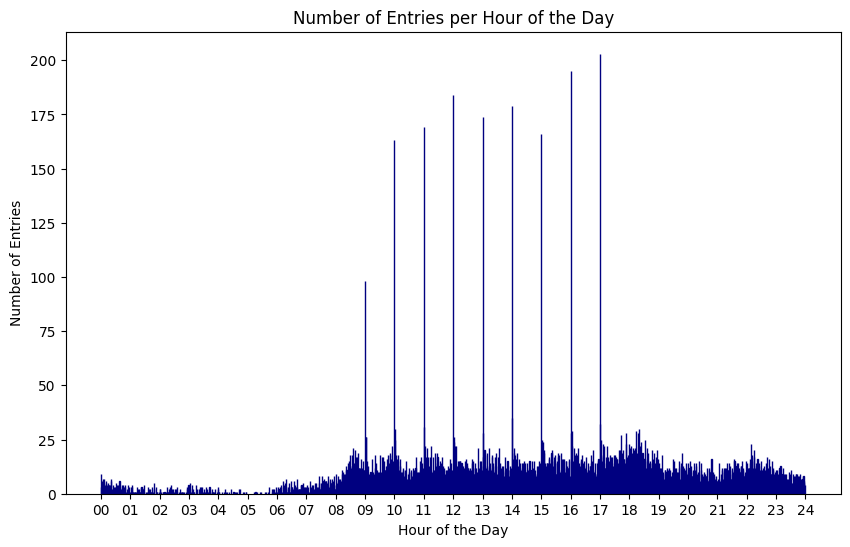

In [ ]:
non_redundant_df['time'] = non_redundant_df['merged_datetime'].dt.time
start_time = pd.to_datetime('18:00:00').time()
end_time = pd.to_datetime('09:00:00').time()

evening_entries = non_redundant_df[(non_redundant_df['time'] >= start_time)]
morning_entries = non_redundant_df[(non_redundant_df['time'] <= end_time)]

night_entries = pd.concat([evening_entries, morning_entries])

num_night_entries = len(night_entries)
total_entries = len(non_redundant_df)


print(f"Number of entries taken between 18:00 and 09:00: {num_night_entries}")
print(f"Number of entries taken between 18:00 and 09:00: {num_night_entries}")
print(f"Percentage of entries taken between 18:00 and 09:00: {(num_night_entries / total_entries) * 100:.2f}%")
print(11/24)


non_redundant_df['minutes_since_midnight'] = non_redundant_df['merged_datetime'].dt.hour * 60 + non_redundant_df['merged_datetime'].dt.minute

# Create a histogram of the minute values
plt.figure(figsize=(10, 6))
plt.hist(non_redundant_df['minutes_since_midnight'], bins=1440, range=(0, 1440), edgecolor='navy', width=0.1)
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Entries')
plt.title('Number of Entries per Hour of the Day')
plt.xticks(range(0, 24))
plt.grid(axis='y')

# Format the x-axis labels to show time in HH:MM format
def format_time(x, pos):
    hours = int(x // 60)
    minutes = int(x % 60)
    return f'{hours:02d}'

plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_time))
plt.xticks(range(0, 1441, 60))  # Set x-ticks every hour
plt.grid(axis='y')

# Show the plot
plt.show()




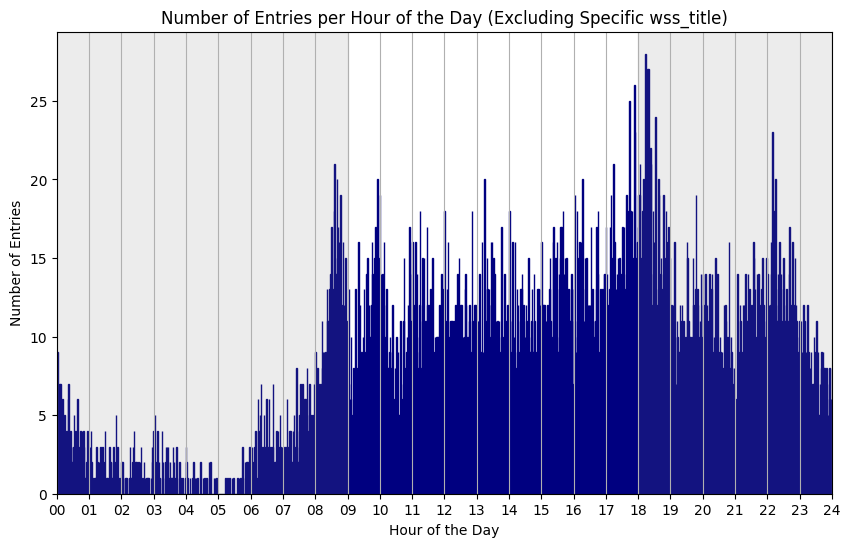

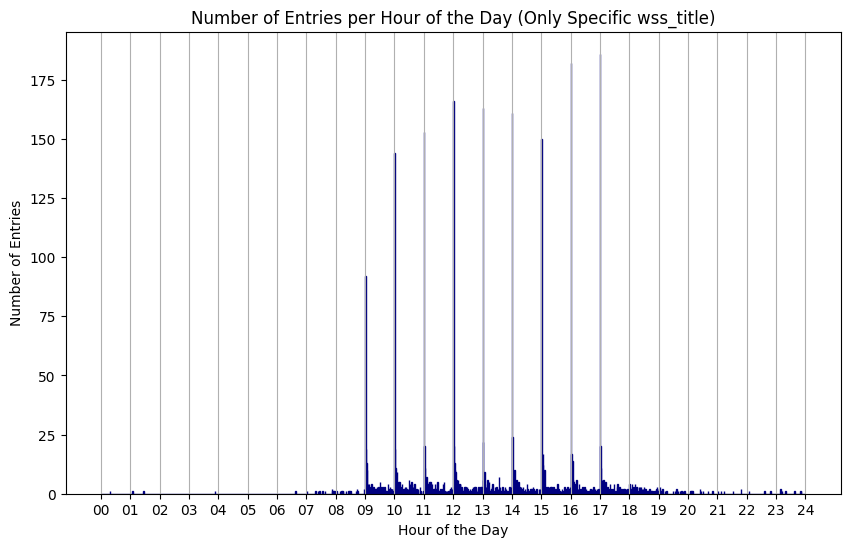

In [ ]:
# Filter the DataFrame to exclude entries with wss_title as "Arda survey - Korean" or "Arda survey - English"
filtered_df_exclude = non_redundant_df[~non_redundant_df['wss_title'].isin(['Arda survey - Korean', 'Arda survey - English'])]

# Create a histogram of the minute values for the filtered dataset (excluding specific wss_title)
plt.figure(figsize=(10, 6))
plt.hist(filtered_df_exclude['minutes_since_midnight'], bins=1440, range=(0, 1440), edgecolor='navy')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Entries')
plt.title('Number of Entries per Hour of the Day (Excluding Specific wss_title)')
plt.xticks(range(0, 1441, 60))  # Set x-ticks every hour
plt.grid(axis='x')
plt.xlim(0, 1440)

plt.axvspan(18 * 60, 24 * 60, color='grey', alpha=0.15)
plt.axvspan(0, 9 * 60, color='grey', alpha=0.15)

plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_time))
plt.show()

# Filter the DataFrame to include only entries with wss_title as "Arda survey - Korean" or "Arda survey - English"
filtered_df_include = non_redundant_df[non_redundant_df['wss_title'].isin(['Arda survey - Korean', 'Arda survey - English'])]

# Create a histogram of the minute values for the filtered dataset (including only specific wss_title)
plt.figure(figsize=(10, 6))
plt.hist(filtered_df_include['minutes_since_midnight'], bins=1440, range=(0, 1440), edgecolor='navy')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Entries')
plt.title('Number of Entries per Hour of the Day (Only Specific wss_title)')
plt.xticks(range(0, 1441, 60))  # Set x-ticks every hour
plt.grid(axis='x')

plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_time))
plt.show()

# __Exporting Shapefiles of Cleaned Data__

In [50]:
# making shapefiles: polylines and points for each participant
# ALL RECORDS

cozie_df = cozie_df.sort_values(by=['id_participant', 'merged_datetime'])

output_dir_paths = os.path.join(base_dir,"shapefiles/paths")
output_dir_points = os.path.join(base_dir,"shapefiles/points")

os.makedirs(output_dir_paths, exist_ok=True)
os.makedirs(output_dir_points, exist_ok=True)
participants = cozie_df['id_participant'].unique()

for participant in participants:
    participant_df = cozie_df[cozie_df['id_participant'] == participant]

    # 1: creating a polyline for each day
    polylines = []
    for date, group in participant_df.groupby('date'):
        points = [Point(xy) for xy in zip(group['longitude'], group['latitude'])]
        if len(points) > 1:
            polyline = LineString(points)
            polylines.append({'geometry': polyline, 'date': date})
    
    if polylines:
        polylines_gdf = gpd.GeoDataFrame(polylines)
        polylines_gdf.set_crs(epsg=4326, inplace=True)
        polylines_gdf.to_file(os.path.join(output_dir_paths, f"participant_{participant}_polylines.shp"))
    
    # 2: creating points with day attribute
    points = gpd.GeoDataFrame(participant_df, geometry=[Point(xy) for xy in zip(participant_df['longitude'], participant_df['latitude'])])
    points = points.select_dtypes(exclude=['timedelta64'])
    points.set_crs(epsg=4326, inplace=True)
    points.to_file(os.path.join(output_dir_points, f"participant_{participant}_points.shp"))



C:\Users\Michele\AppData\Local\Temp\ipykernel_26192\3709459755.py:33: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  points.to_file(os.path.join(output_dir_points, f"participant_{participant}_points.shp"))
d:\Desktop\MSc Thesis - Copy\scripts\.venvth\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'id_participant' to 'id_partici'
  ogr_write(
d:\Desktop\MSc Thesis - Copy\scripts\.venvth\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'location_change' to 'location_c'
  ogr_write(
d:\Desktop\MSc Thesis - Copy\scripts\.venvth\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'q_activity_change_leisure' to 'q_activity'
  ogr_write(
d:\Desktop\MSc Thesis - Copy\scripts\.venvth\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'q_activity_change_meal' to 'q_activi_1'
  ogr_write(
d:\Desk

In [ ]:
# making shapefiles: polylines and points for each participant
# NON-REDUNDANT RECORDS

non_redundant_df = non_redundant_df.sort_values(by=['id_participant', 'merged_datetime'])

output_dir_paths_non_redundant = os.path.join(base_dir,f"shapefiles/paths_non_redundant_{time_threshold.seconds}")
output_dir_points_non_redundant = os.path.join(base_dir,f"shapefiles/points_non_redundant_{time_threshold.seconds}")

os.makedirs(output_dir_paths_non_redundant, exist_ok=True)
os.makedirs(output_dir_points_non_redundant, exist_ok=True)
participants = non_redundant_df['id_participant'].unique()

for participant in participants:
    participant_df = non_redundant_df[non_redundant_df['id_participant'] == participant]

    # 1: creating a polyline for each day
    polylines = []
    for date, group in participant_df.groupby('date'):
        points = [Point(xy) for xy in zip(group['longitude'], group['latitude'])]
        if len(points) > 1:
            polyline = LineString(points)
            polylines.append({'geometry': polyline, 'date': date})
    
    if polylines:
        polylines_gdf = gpd.GeoDataFrame(polylines)
        polylines_gdf.set_crs(epsg=4326, inplace=True)
        polylines_gdf.to_file(os.path.join(output_dir_paths_non_redundant, f"participant_{participant}_polylines.shp"))
    
    # 2: creating points with day attribute
    points = gpd.GeoDataFrame(participant_df, geometry=[Point(xy) for xy in zip(participant_df['longitude'], participant_df['latitude'])])
    points = points.select_dtypes(exclude=['timedelta64'])
    points.set_crs(epsg=4326, inplace=True)
    points.to_file(os.path.join(output_dir_points_non_redundant, f"participant_{participant}_points.shp"))



C:\Users\Michele\AppData\Local\Temp\ipykernel_12352\2745704966.py:33: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  points.to_file(os.path.join(output_dir_points_non_redundant, f"participant_{participant}_points.shp"))
d:\Desktop\MSc Thesis - Copy\scripts\.venvth\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'id_participant' to 'id_partici'
  ogr_write(
d:\Desktop\MSc Thesis - Copy\scripts\.venvth\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'location_change' to 'location_c'
  ogr_write(
d:\Desktop\MSc Thesis - Copy\scripts\.venvth\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'q_activity_change_leisure' to 'q_activity'
  ogr_write(
d:\Desktop\MSc Thesis - Copy\scripts\.venvth\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'q_activity_change_meal' to 'q_activi_1'
  ogr_

In [ ]:
# making shapefiles: polylines and points for each participant
# FILTERED RECORDS

filtered_df = filtered_df.sort_values(by=['id_participant', 'merged_datetime'])

output_dir_paths_filtered = os.path.join(base_dir, f"shapefiles/paths_filtered")
output_dir_points_filtered = os.path.join(base_dir, f"shapefiles/points_filtered")


os.makedirs(output_dir_paths_filtered, exist_ok=True)
os.makedirs(output_dir_points_filtered, exist_ok=True)
participants = filtered_df['id_participant'].unique()

for participant in participants:
    participant_df = filtered_df[filtered_df['id_participant'] == participant]

    # 1: creating a polyline for each day
    polylines = []
    for date, group in participant_df.groupby('date'):
        points = [Point(xy) for xy in zip(group['longitude'], group['latitude'])]
        if len(points) > 1:
            polyline = LineString(points)
            polylines.append({'geometry': polyline, 'date': date})
    
    if polylines:
        polylines_gdf = gpd.GeoDataFrame(polylines)
        polylines_gdf.set_crs(epsg=4326, inplace=True)
        polylines_gdf.to_file(os.path.join(output_dir_paths_filtered, f"participant_{participant}_polylines.shp"))
    
    # 2: creating points with day attribute
    points = gpd.GeoDataFrame(participant_df, geometry=[Point(xy) for xy in zip(participant_df['longitude'], participant_df['latitude'])])
    points = points.select_dtypes(exclude=['timedelta64'])
    points.set_crs(epsg=4326, inplace=True)
    points.to_file(os.path.join(output_dir_points_filtered, f"participant_{participant}_points.shp"))


C:\Users\Michele\AppData\Local\Temp\ipykernel_12352\4289845932.py:33: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  points.to_file(os.path.join(output_dir_points_filtered, f"participant_{participant}_points.shp"))
d:\Desktop\MSc Thesis - Copy\scripts\.venvth\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'id_participant' to 'id_partici'
  ogr_write(
d:\Desktop\MSc Thesis - Copy\scripts\.venvth\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'location_change' to 'location_c'
  ogr_write(
d:\Desktop\MSc Thesis - Copy\scripts\.venvth\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'q_activity_change_leisure' to 'q_activity'
  ogr_write(
d:\Desktop\MSc Thesis - Copy\scripts\.venvth\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'q_activity_change_meal' to 'q_activi_1'
  ogr_write

In [ ]:
# testing sorting chronologically using other timestamp fields
timestamp_test_df = filtered_df.copy()
timestamp_test_df['datetime_ts_location'] = pd.to_datetime(timestamp_test_df.ts_timestamp_location, format='ISO8601')
timestamp_test_df['datetime_ws_location'] = pd.to_datetime(timestamp_test_df.ws_timestamp_location, format='ISO8601')



timestamp_test_df['merged_timestamp'] = timestamp_test_df['datetime_ts_location'].combine_first(timestamp_test_df['datetime_ws_location'])
timestamp_test_df['merged_date'] = timestamp_test_df['merged_timestamp'].dt.date







timestamp_test_df = timestamp_test_df.sort_values(by=['id_participant', 'merged_timestamp'])

timestamp_test_df['location'] = timestamp_test_df[
    ['q_location_leisure', 'q_location_meal', 'q_location_other', 'q_location_studying', 'q_location_working']
].apply(lambda row: row.dropna().iloc[0] if not row.dropna().empty else None, axis=1)




# re-calculating the previous-coordinate fields
timestamp_test_df['prev_lat'] = timestamp_test_df.groupby('id_participant')['latitude'].shift()
timestamp_test_df['prev_lon'] = timestamp_test_df.groupby('id_participant')['longitude'].shift()
timestamp_test_df['prev_time'] = timestamp_test_df.groupby('id_participant')['merged_datetime'].shift()
timestamp_test_df['time_diff'] = (timestamp_test_df['merged_datetime'] - timestamp_test_df['prev_time']).dt.total_seconds()
timestamp_test_df['geo_distance'] = timestamp_test_df.apply(
    lambda row: geodesic((row['latitude'], row['longitude']), 
                         (row['prev_lat'], row['prev_lon'])
                        ).meters if pd.notnull(row['prev_lat']) and pd.notnull(row['prev_lon']) else 0,
    axis=1
)


# getting the coordinates and timestamp of next location
timestamp_test_df['next_lat'] = timestamp_test_df.groupby('id_participant')['latitude'].shift(-1)
timestamp_test_df['next_lon'] = timestamp_test_df.groupby('id_participant')['longitude'].shift(-1)
timestamp_test_df['next_time'] = timestamp_test_df.groupby('id_participant')['merged_datetime'].shift(-1)

# distance from current to next location
timestamp_test_df['next_geo_distance'] = timestamp_test_df.groupby('id_participant')['geo_distance'].shift(-1)

# distance from previous to next location
timestamp_test_df['prev_next_geo_distance'] = timestamp_test_df.apply(
    lambda row: geodesic((row['prev_lat'], row['prev_lon']),
                         (row['next_lat'], row['next_lon'])).meters
    if pd.notnull(row['prev_lat']) and pd.notnull(row['prev_lon']) and 
       pd.notnull(row['next_lat']) and pd.notnull(row['next_lon']) else 0, axis=1
)

# computing the Basic Distance Ratio between the three points (previous, current, next)

timestamp_test_df['distance_ratio'] = timestamp_test_df['prev_next_geo_distance'] / (timestamp_test_df['geo_distance'] + timestamp_test_df['next_geo_distance'])
timestamp_test_df['distance_ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)
timestamp_test_df['distance_ratio'].fillna(0, inplace=True)

# implementing a time-scaling factor
timestamp_test_df['next_time_diff'] = timestamp_test_df.groupby('id_participant')['time_diff'].shift(-1)
timestamp_test_df['max_time_diff'] = timestamp_test_df[['time_diff', 'next_time_diff']].max(axis=1)
timestamp_test_df['time_weight'] = 1 / (1 + np.log1p(timestamp_test_df['max_time_diff']/60)) # time weight function in minutes (not seconds)

timestamp_test_df['adjusted_distance_ratio'] = (
    timestamp_test_df['distance_ratio'] * timestamp_test_df['time_weight']
)
# making shapefiles: polylines and points for each participant
# TEST WITH DIFFERENT TIMESTAMPS RECORDS

timestamp_test_df = timestamp_test_df.sort_values(by=['id_participant', 'merged_timestamp'])

output_dir_paths_test = os.path.join(base_dir, f"shapefiles/paths_timestamp_test")
output_dir_points_test = os.path.join(base_dir, f"shapefiles/points_timestamp_test")



os.makedirs(output_dir_paths_test, exist_ok=True)
os.makedirs(output_dir_points_test, exist_ok=True)
participants = timestamp_test_df['id_participant'].unique()

for participant in participants:
    participant_df = timestamp_test_df[timestamp_test_df['id_participant'] == participant]

    # 1: creating a polyline for each day
    polylines = []
    for date, group in participant_df.groupby('merged_date'):
        points = [Point(xy) for xy in zip(group['longitude'], group['latitude'])]
        if len(points) > 1:
            polyline = LineString(points)
            polylines.append({'geometry': polyline, 'date': date})
    
    if polylines:
        polylines_gdf = gpd.GeoDataFrame(polylines)
        polylines_gdf.set_crs(epsg=4326, inplace=True)
        polylines_gdf.to_file(os.path.join(output_dir_paths_test, f"participant_{participant}_polylines.shp"))
    
    # 2: creating points with day attribute
    points = gpd.GeoDataFrame(participant_df, geometry=[Point(xy) for xy in zip(participant_df['longitude'], participant_df['latitude'])])
    points = points.select_dtypes(exclude=['timedelta64'])
    points.set_crs(epsg=4326, inplace=True)
    points.to_file(os.path.join(output_dir_points_test, f"participant_{participant}_points.shp"))


C:\Users\Michele\AppData\Local\Temp\ipykernel_12352\1712768601.py:34: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  points.to_file(os.path.join(output_dir_points_test, f"participant_{participant}_points.shp"))
d:\Desktop\MSc Thesis - Copy\scripts\.venvth\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'id_participant' to 'id_partici'
  ogr_write(
d:\Desktop\MSc Thesis - Copy\scripts\.venvth\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'location_change' to 'location_c'
  ogr_write(
d:\Desktop\MSc Thesis - Copy\scripts\.venvth\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'q_activity_change_leisure' to 'q_activity'
  ogr_write(
d:\Desktop\MSc Thesis - Copy\scripts\.venvth\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'q_activity_change_meal' to 'q_activi_1'
  ogr_write(
d:

In [51]:
# Export the filtered points to a CSV file
output_csv_filtered = os.path.join(base_dir, f"filtered_points.csv")

filtered_df.to_csv(output_csv_filtered, index=False)